In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def read_benchstat_csv(infile):
    df = pd.read_csv(infile)
    df.columns=['_name', 'time', '_time_sd']

    name_parts = df['_name'].str.extract(r'(?P<name>[^/]+)/size=(?P<size>\d+)-(?P<cpus>\d+)')
    name_parts = name_parts.astype({'size': 'int32', 'cpus': 'int32'})

    time_sd = df['_time_sd'].str.extract(r'(\d+)%', expand=False).astype('float64')
    time_sd = time_sd / 100 * df.time
    time_sd.name = 'time_sd'
    
    df = pd.concat([name_parts, df.time, time_sd], axis=1)
    return df.set_index(['name', 'size'])

In [3]:
from glob import glob
glob('./*.csv')

['./03c422e.csv', './d6683f3.csv', './56631ae.csv', './2521f4e.csv']

In [4]:
df = read_benchstat_csv('56631ae.csv')
df

cpus        time      time_sd
name       size                                
Fork       64        8     5999.11      59.9911
           256       8    17384.40     173.8440
           1024      8    66948.00     669.4800
           4096      8   429723.00    4297.2300
           16384     8  2036990.00  346288.3000
SetCursor  64        8    12226.90     489.0760
           256       8    54817.60    2740.8800
           1024      8   247800.00    7434.0000
           4096      8   880841.00   26425.2300
           16384     8  4526960.00  181078.4000
InsertChar 64        8    19642.30     589.2690
           256       8    80911.20    5663.7840
           1024      8   332275.00    3322.7500
           4096      8  1223370.00   12233.7000
           16384     8  6461600.00   64616.0000
DeleteChar 64        8    18989.90     569.6970
           256       8    81676.00    4900.5600
           1024      8   349297.00   34929.7000
           4096      8  1241460.00       0.0000
           16384     8  6549550.00  130991.0000
Merge      64        8    30857.20     308.5720
           256       8   132626.00    1326.2600
           1024      8   528265.00    5282.6500
           4096      8  2030690.00       0.0000
           16384     8  9606400.00   96064.0000

In [54]:
from matplotlib.ticker import EngFormatter
from numpy.polynomial import Polynomial

def plot_time_vs_size(size, time_sec, time_sd_sec):
    fig, ax = plt.subplots()
    ax.grid(True, which='both')

    # x axis configuration
    logx_min, logx_max = 5, 15
    logx_num = logx_max - logx_min + 1
    ax.set_xscale('log', basex=2)
    ax.set_xticks(np.logspace(logx_min, logx_max, num=logx_num, base=2))
    ax.set_xlabel('List size')

    # y axis configuration
    ax.set_yscale('log')
    y_formatter = EngFormatter(unit='s')
    ax.yaxis.set_minor_formatter(y_formatter)
    ax.yaxis.set_major_formatter(y_formatter)
    ax.set_ylabel('Time per operation')

    plt.errorbar(size, time_sec, fmt='o', yerr=time_sd_sec)
    
    fit = Polynomial.fit(size, time_sec, deg=2)
    _, c1, c2 = fit
    print(f'time ~ {c1*1e3:.3f}*n + {c2*1e3:.3f}*n^2 ms')
    plt.plot(size, fit(size))
    return ax

time ~ 1.022*n + 0.101*n^2 ms


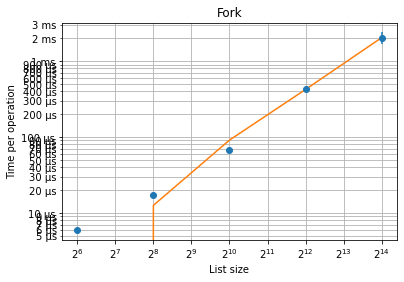

In [55]:
# Analysing fork operation
fork = df.xs('Fork')

ax = plot_time_vs_size(fork.index, fork.time * 1e-9, fork.time_sd * 1e-9)
_ = ax.set_title('Fork')

time ~ 2.250*n + 0.334*n^2 ms


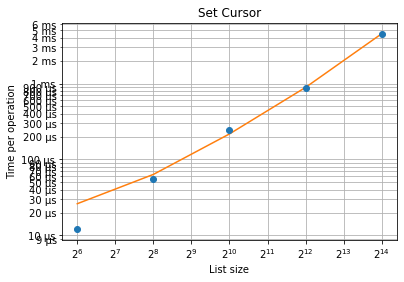

In [56]:
# Analysing set cursor operation
set_cursor = df.xs('SetCursor')

xs = set_cursor.index
ax = plot_time_vs_size(xs, set_cursor.time * 1e-9, set_cursor.time_sd * 1e-9)
_ = ax.set_title('Set Cursor')

/home/bkim/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


time ~ 0.962*n + 0.192*n^2 ms


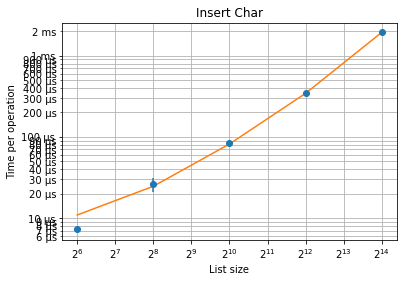

In [57]:
# Analysing insert char
_char = df.xs('InsertChar')

# insert char is measured together with set cursor, so we need to remove its contributions.
char_time = _char.time - set_cursor.time
char_time_sd = np.sqrt(_char.time_sd**2 - set_cursor.time_sd**2)

ax = plot_time_vs_size(_char.index, char_time * 1e-9, char_time_sd * 1e-9)
_ = ax.set_title('Insert Char')

/home/bkim/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


time ~ 1.004*n + 0.196*n^2 ms


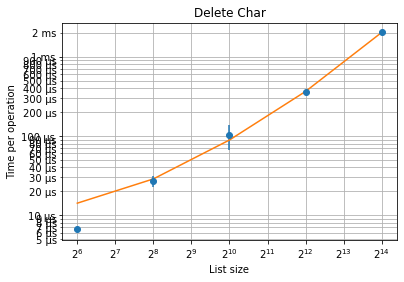

In [58]:
# Analysing delete char
_char = df.xs('DeleteChar')

# delete char is measured together with set cursor, so we need to remove its contributions.
char_time = _char.time - set_cursor.time
char_time_sd = np.sqrt(_char.time_sd**2 - set_cursor.time_sd**2)

ax = plot_time_vs_size(_char.index, char_time * 1e-9, char_time_sd * 1e-9)
_ = ax.set_title('Delete Char')

time ~ 4.779*n + 0.497*n^2 ms


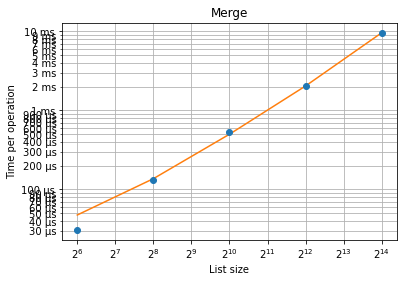

In [59]:
# Analysing merge experiment
_merge = df.xs("Merge")

ax = plot_time_vs_size(_merge.index, _merge.time * 1e-9, _merge.time_sd * 1e-9)
_ = ax.set_title('Merge')